In [1]:
from psfr import psfr

stack_psf = psfr.stack_psf
psf_error = psfr.psf_error_map

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_84033/3660693668.py:48: RuntimeWarning: invalid value encountered in log10
  ax[0, i].imshow(np.log10(star))


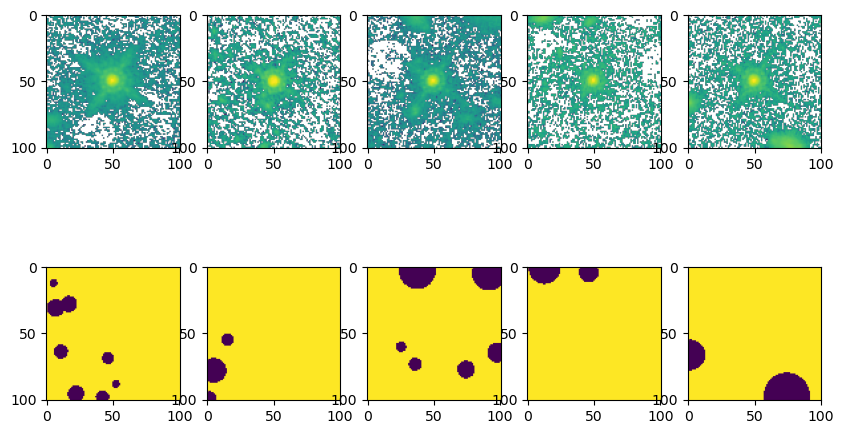

In [7]:
import glob
from astropy.io import fits
import numpy as np
from regions import Regions
from astropy.wcs import WCS
import matplotlib.pyplot as plt

system_name = "J1442+4055"

# Get list of star FITS files and mask region files
star_list = glob.glob(f'cutout_data/{system_name}/F160W/stars/star*.fits')
mask_list = glob.glob(f'cutout_data/{system_name}/F160W/noise_maps/mask*.reg')

# Create a list to hold the numpy arrays
star_data_list = []
mask_data_list = []

# Loop through each star FITS file
for file in star_list:
    with fits.open(file) as hdul:
        data = hdul[0].data  
        star_data_list.append(np.array(data))  


with fits.open(star_list[0]) as hdul:
    image_shape = hdul[0].data.shape
    wcs = WCS(hdul[0].header)

for mask_file in mask_list:
    regions = Regions.read(mask_file)

    mask = np.zeros(image_shape, dtype=bool)
    for region in regions:
            mask_region = region.to_mask(mode='center')
            region_mask = mask_region.to_image(image_shape)

            mask |= region_mask.astype(bool)

    mask = ~mask
    mask_data_list.append(mask)

def make_mask_grid(star_list, mask_list):

    fig, ax = plt.subplots(2, len(star_list), figsize=(10, 6))

    for i, star in enumerate(star_list):

        ax[0, i].imshow(np.log10(star))
        ax[1, i].imshow(mask_list[i])

    plt.show()

make_mask_grid(star_data_list, mask_data_list)

psf_returns = stack_psf(star_list = star_data_list, oversampling = 3, mask_list=mask_data_list)

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_84033/2794978567.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(psf_guess), origin='lower')


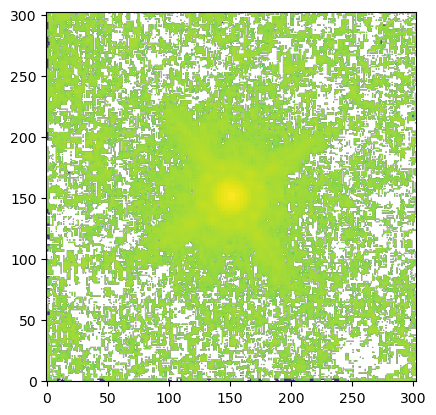

In [8]:
psf_guess = psf_returns[0]
center_list = np.array(psf_returns[1])
plt.imshow(np.log10(psf_guess), origin='lower')

new_center_list = []

for i, star in enumerate(center_list):

    new_center_list.append([center_list[i][0], center_list[i][1]])

new_center_list = np.array(new_center_list)

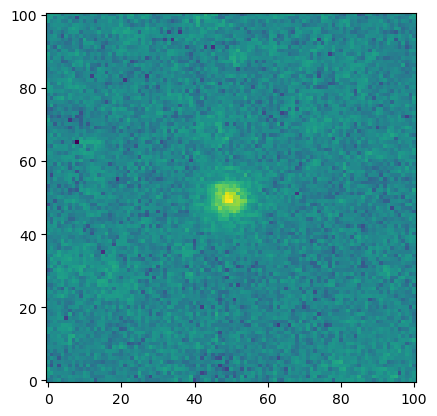

In [9]:
error_map = psf_error(star_data_list, psf_guess, new_center_list, oversampling=3, mask_list=mask_data_list)

plt.imshow(np.log10(error_map), origin='lower')

In [10]:
np.savetxt(f'cutout_data/{system_name}/F160W/psf_variance.txt', error_map)